In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import os
from glob import glob
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
#from dataloader import inaturalist
#from model import Classifier
import torch.optim as optim
import time
import gc
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [ ]:
# For Sports Classification
!gdown 1VEDTIGOavtFKncqXpyF2jtxKogoF7Jnc

Downloading...
From (original): https://drive.google.com/uc?id=1VEDTIGOavtFKncqXpyF2jtxKogoF7Jnc
From (redirected): https://drive.google.com/uc?id=1VEDTIGOavtFKncqXpyF2jtxKogoF7Jnc&confirm=t&uuid=6cb5a0d0-48a9-445c-a558-b6db0ba84b5e
To: /content/sports_classification.zip
100% 445M/445M [00:04<00:00, 91.3MB/s]


In [ ]:

!unzip sports_classification.zip

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, mode = 'train', transform = True):
        self.data_dir = root_dir
        self.mode = mode
        self.transforms = transform
        self._init_dataset()
        if transform:
            self._init_transform()

    def _init_dataset(self):
        self.files = []
        self.labels = []

        if self.mode == "train":
          path = os.path.join(self.data_dir, "train")
        elif self.mode == "test":
          path = os.path.join(self.data_dir, "test")

        for i, dir in enumerate(os.listdir(path)):
          ims = os.listdir(os.path.join(path, dir))

          ims_final = []
          label_final = []
          for im in ims:
            if im.endswith(".jpg"):
              ims_final.append(os.path.join(path, dir, im))
              label_final.append(i)

          self.files.extend(ims_final)
          self.labels.extend(label_final)



    def _init_transform(self):
        self.transform = transforms.Compose([
            # Useful link for this part: https://pytorch.org/vision/stable/transforms.html

            # transforms.Resize((227, 227)), # AlexNet
            # transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomRotation(degrees=30),
            transforms.Resize((32, 32)), # LeNet
            # transforms.Resize((224, 224)), # VGGNet
            transforms.ToTensor(),
            # transforms.Normalize((0,), (1,))
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        image = self.files[index]
        label = self.labels[index]
        img = Image.open(image).convert('RGB')
        img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.files)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        #------YOUR CODE HERE-----#

        # # VGGNet
        # self.convolutions = nn.Sequential(
        #     nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=3, stride=2),

        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=3, stride=2),

        #     nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=3, stride=2),

        #     nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=3, stride=2),

        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=3, stride=2)
        # )

        # self.fully_connected = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(18432, 4096),
        #     nn.ReLU(),

        #     nn.Linear(4096, 4096),
        #     nn.ReLU(),

        #     nn.Linear(4096, num_classes)
        # )



        # LeNet
        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.Tanh()
        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )




        #  # AlexNet

        # self.convolutions = nn.Sequential(
        #     nn.Conv2d(3, 96, 11, 4),
        #     nn.ReLU(),
        #     nn.MaxPool2d(3, stride=2),

        #     nn.Conv2d(96, 256, 5, 1, 2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(3, 2),

        #     nn.Conv2d(256, 384, 3, 1, 1),
        #     nn.ReLU(),

        #     nn.Conv2d(384, 384, 3, 1, 1),
        #     nn.ReLU(),

        #     nn.Conv2d(384, 256, 3, 1, 1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(3, 2)
        # )

        # self.fully_connected = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(256*6*6, 4096),
        #     nn.ReLU(),

        #     nn.Linear(4096, 4096),
        #     nn.ReLU(),

        #     nn.Linear(4096, num_classes)
        # )


    def forward(self, x):
        #------YOUR CODE HERE-----#
        x = self.convolutions(x)
        x = self.fully_connected(x)

        return x


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#------YOUR CODE HERE-----#
batch_size = 128
epochs = 20
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

############################################# DEFINE DATALOADER #####################################################
#------YOUR CODE HERE-----#
'''
Load the Dataset in Dataloader
'''

dataset = ClassificationDataset('/content')
testset = ClassificationDataset('/content', mode='test')
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

################################### DEFINE LOSS FUNCTION, MODEL AND OPTIMIZER ######################################
# USEFUL LINK: https://pytorch.org/docs/stable/nn.html#loss-functions
#---Define the loss function to use, model object and the optimizer for training---#
#------YOUR CODE HERE-----#

import torchvision.models as models


# model = CNNModel(num_classes=100).to(device) # All models except resnet
model = models.resnet18().to(device) # ResNet
# model = models.vgg16().to(device)
model.fc = nn.Linear(512, 100)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

#################################### HELPER FUNCTIONS ##############################################################

def accuracy(y_pred, y):
    _, predicted = torch.max(y_pred.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct/total

def make_tensor(tensor):
  if torch.cuda.is_available():
    return torch.cuda.FloatTensor(tensor)
  else:
    return torch.FloatTensor(tensor)

####################################################################################################################

def train(model, dataset, optimizer, criterion, device):
    '''
    Write the function to train the model for one epoch
    Feel free to use the accuracy function defined above as an extra metric to track
    '''
    #------YOUR CODE HERE-----#
    train_iter = iter(dataset)
    model.train()
    acc_vals = []
    loss_vals = []
    for i, (data, targets) in enumerate(train_iter):
      data = data.to(device=device)
      targets = targets.to(device=device)

      outputs = model.forward(data)
      loss = criterion(outputs, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      acc = accuracy(outputs, targets)
      acc_vals.append(acc)
      loss_val = loss.item()
      loss_vals.append(loss_val)

    final_accs = np.array(acc_vals)
    final_loss = np.array(loss_vals)
    return np.mean(final_accs), np.mean(final_loss)



def test(model, dataset, criterion, device):
    '''
    Write the function to test the model after entire training
    Feel free to use the accuracy function defined above as an extra metric to track
    '''
    #------YOUR CODE HERE-----#
    model.eval()
    acc_vals = []
    loss_vals = []
    with torch.no_grad():
      for data, targets in dataset:
        data = data.to(device=device)
        targets = targets.to(device=device)

        outputs = model.forward(data)
        loss = criterion(outputs, targets)

        acc = accuracy(outputs, targets)
        acc_vals.append(acc)
        loss_val = loss.item()
        loss_vals.append(loss_val)

    final_accs = np.array(acc_vals)
    final_loss = np.array(loss_vals)
    return np.mean(final_accs), np.mean(final_loss)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

################################################### TRAINING #######################################################

#Training and Validation
train_accs = []
test_accs = []
train_losses = []
test_losses = []

for epoch in range(epochs):
    '''
    Insert code to train and evaluate the model (Hint: use the functions you previously made :P)
    Also save the weights of the model in a checkpoint directory
    '''
    #------YOUR CODE HERE-----#
    print(epoch)

    train_acc, train_loss = train(model, trainloader, optimizer=optimizer, criterion=loss, device=device)
    test_acc, test_loss = test(model, testloader, criterion=loss, device=device)

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)


print("OVERALL TRAINING COMPLETE")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
OVERALL TRAINING COMPLETE


In [ ]:
print(f"Train accuracy: {max(train_accs): .6f}")
print(f"Test accuracy: {max(test_accs): .6f}")

Train accuracy:  0.982289
Test accuracy:  0.488887


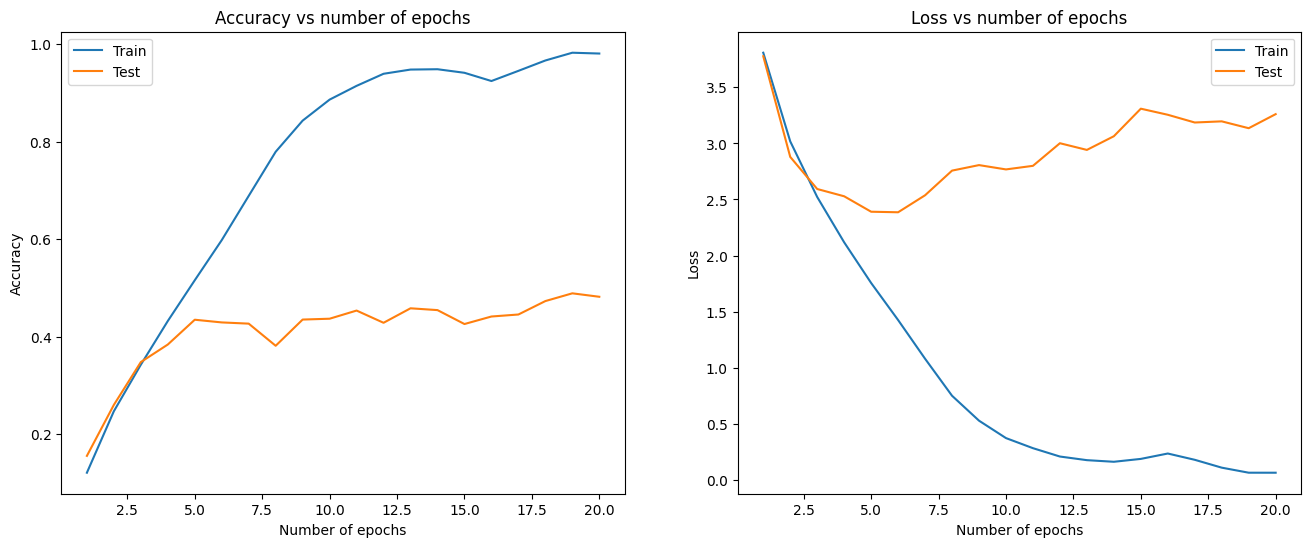

In [ ]:
#------YOUR CODE HERE-----#
# Plot the Training and Validation Curve
x_vals = range(1, 21)

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_vals, train_accs, label='Train')
ax1.plot(x_vals, test_accs, label='Test')
ax1.set_xlabel("Number of epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy vs number of epochs")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x_vals, train_losses, label='Train')
ax2.plot(x_vals, test_losses, label='Test')
ax2.set_xlabel("Number of epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss vs number of epochs")
ax2.legend()
plt.show()

In [ ]:
class TempDataset(Dataset):
    def __init__(self, mode = 'train', transform = True):
        self.mode = mode
        self.transforms = transform
        self._init_dataset()
        if transform:
            self._init_transform()

    def _init_dataset(self):
        self.files = []
        self.labels = []
        path = os.path.join("/content", "Images")

        for image in os.listdir(path):
          self.files.append(os.path.join(path, image))
          self.labels.append(0)



    def _init_transform(self):
        self.transform = transforms.Compose([
            #------YOUR CODE HERE-----#
            # Useful link for this part: https://pytorch.org/vision/stable/transforms.html

            # transforms.Resize((227, 227)), # AlexNet
            # transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomRotation(degrees=30),
            # transforms.Resize((32, 32)), # LeNet
            transforms.Resize((224, 224)), # VGGNet
            transforms.ToTensor(),
            # transforms.Normalize((0,), (1,))
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        #------YOUR CODE HERE-----#
        image = self.files[index]
        label = self.labels[index]
        img = Image.open(image).convert('RGB')
        img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.files)


images = TempDataset()
loader = DataLoader(images, batch_size=1, num_workers=2)
outputs = []

with torch.no_grad():
  for i, (img, l) in enumerate(iter(loader)):
    img = img.to(device)
    l = l.to(device)
    output = model.forward(img)
    outputs.append(torch.max(output, 1)[1])


print(outputs)

[tensor([86], device='cuda:0'), tensor([86], device='cuda:0'), tensor([86], device='cuda:0'), tensor([86], device='cuda:0'), tensor([86], device='cuda:0'), tensor([86], device='cuda:0'), tensor([86], device='cuda:0'), tensor([86], device='cuda:0'), tensor([86], device='cuda:0'), tensor([86], device='cuda:0')]


In [ ]:
get_classlabels = {}
dirs = os.listdir(os.path.join("/content", "test"))

for i in range(len(dirs)):
  get_classlabels[i] = dirs[i]

print(get_classlabels)

{0: 'bmx', 1: 'figure skating men', 2: 'horseshoe pitching', 3: 'weightlifting', 4: 'figure skating pairs', 5: 'basketball', 6: 'hurdles', 7: 'swimming', 8: 'bull riding', 9: 'billiards', 10: 'balance beam', 11: 'hockey', 12: 'shot put', 13: 'bowling', 14: 'pole climbing', 15: 'sidecar racing', 16: 'log rolling', 17: 'roller derby', 18: 'hydroplane racing', 19: 'skydiving', 20: 'figure skating women', 21: 'frisbee', 22: 'uneven bars', 23: 'bungee jumping', 24: 'tug of war', 25: 'nascar racing', 26: 'jousting', 27: 'field hockey', 28: 'arm wrestling', 29: 'motorcycle racing', 30: 'sailboat racing', 31: 'steer wrestling', 32: 'axe throwing', 33: 'golf', 34: 'football', 35: 'ice yachting', 36: 'cheerleading', 37: 'gaga', 38: 'fencing', 39: 'polo', 40: 'ice climbing', 41: 'sumo wrestling', 42: 'high jump', 43: 'rings', 44: 'water polo', 45: 'judo', 46: 'luge', 47: 'archery', 48: 'snowmobile racing', 49: 'surfing', 50: 'giant slalom', 51: 'javelin', 52: 'horse jumping', 53: 'sky surfing', 5

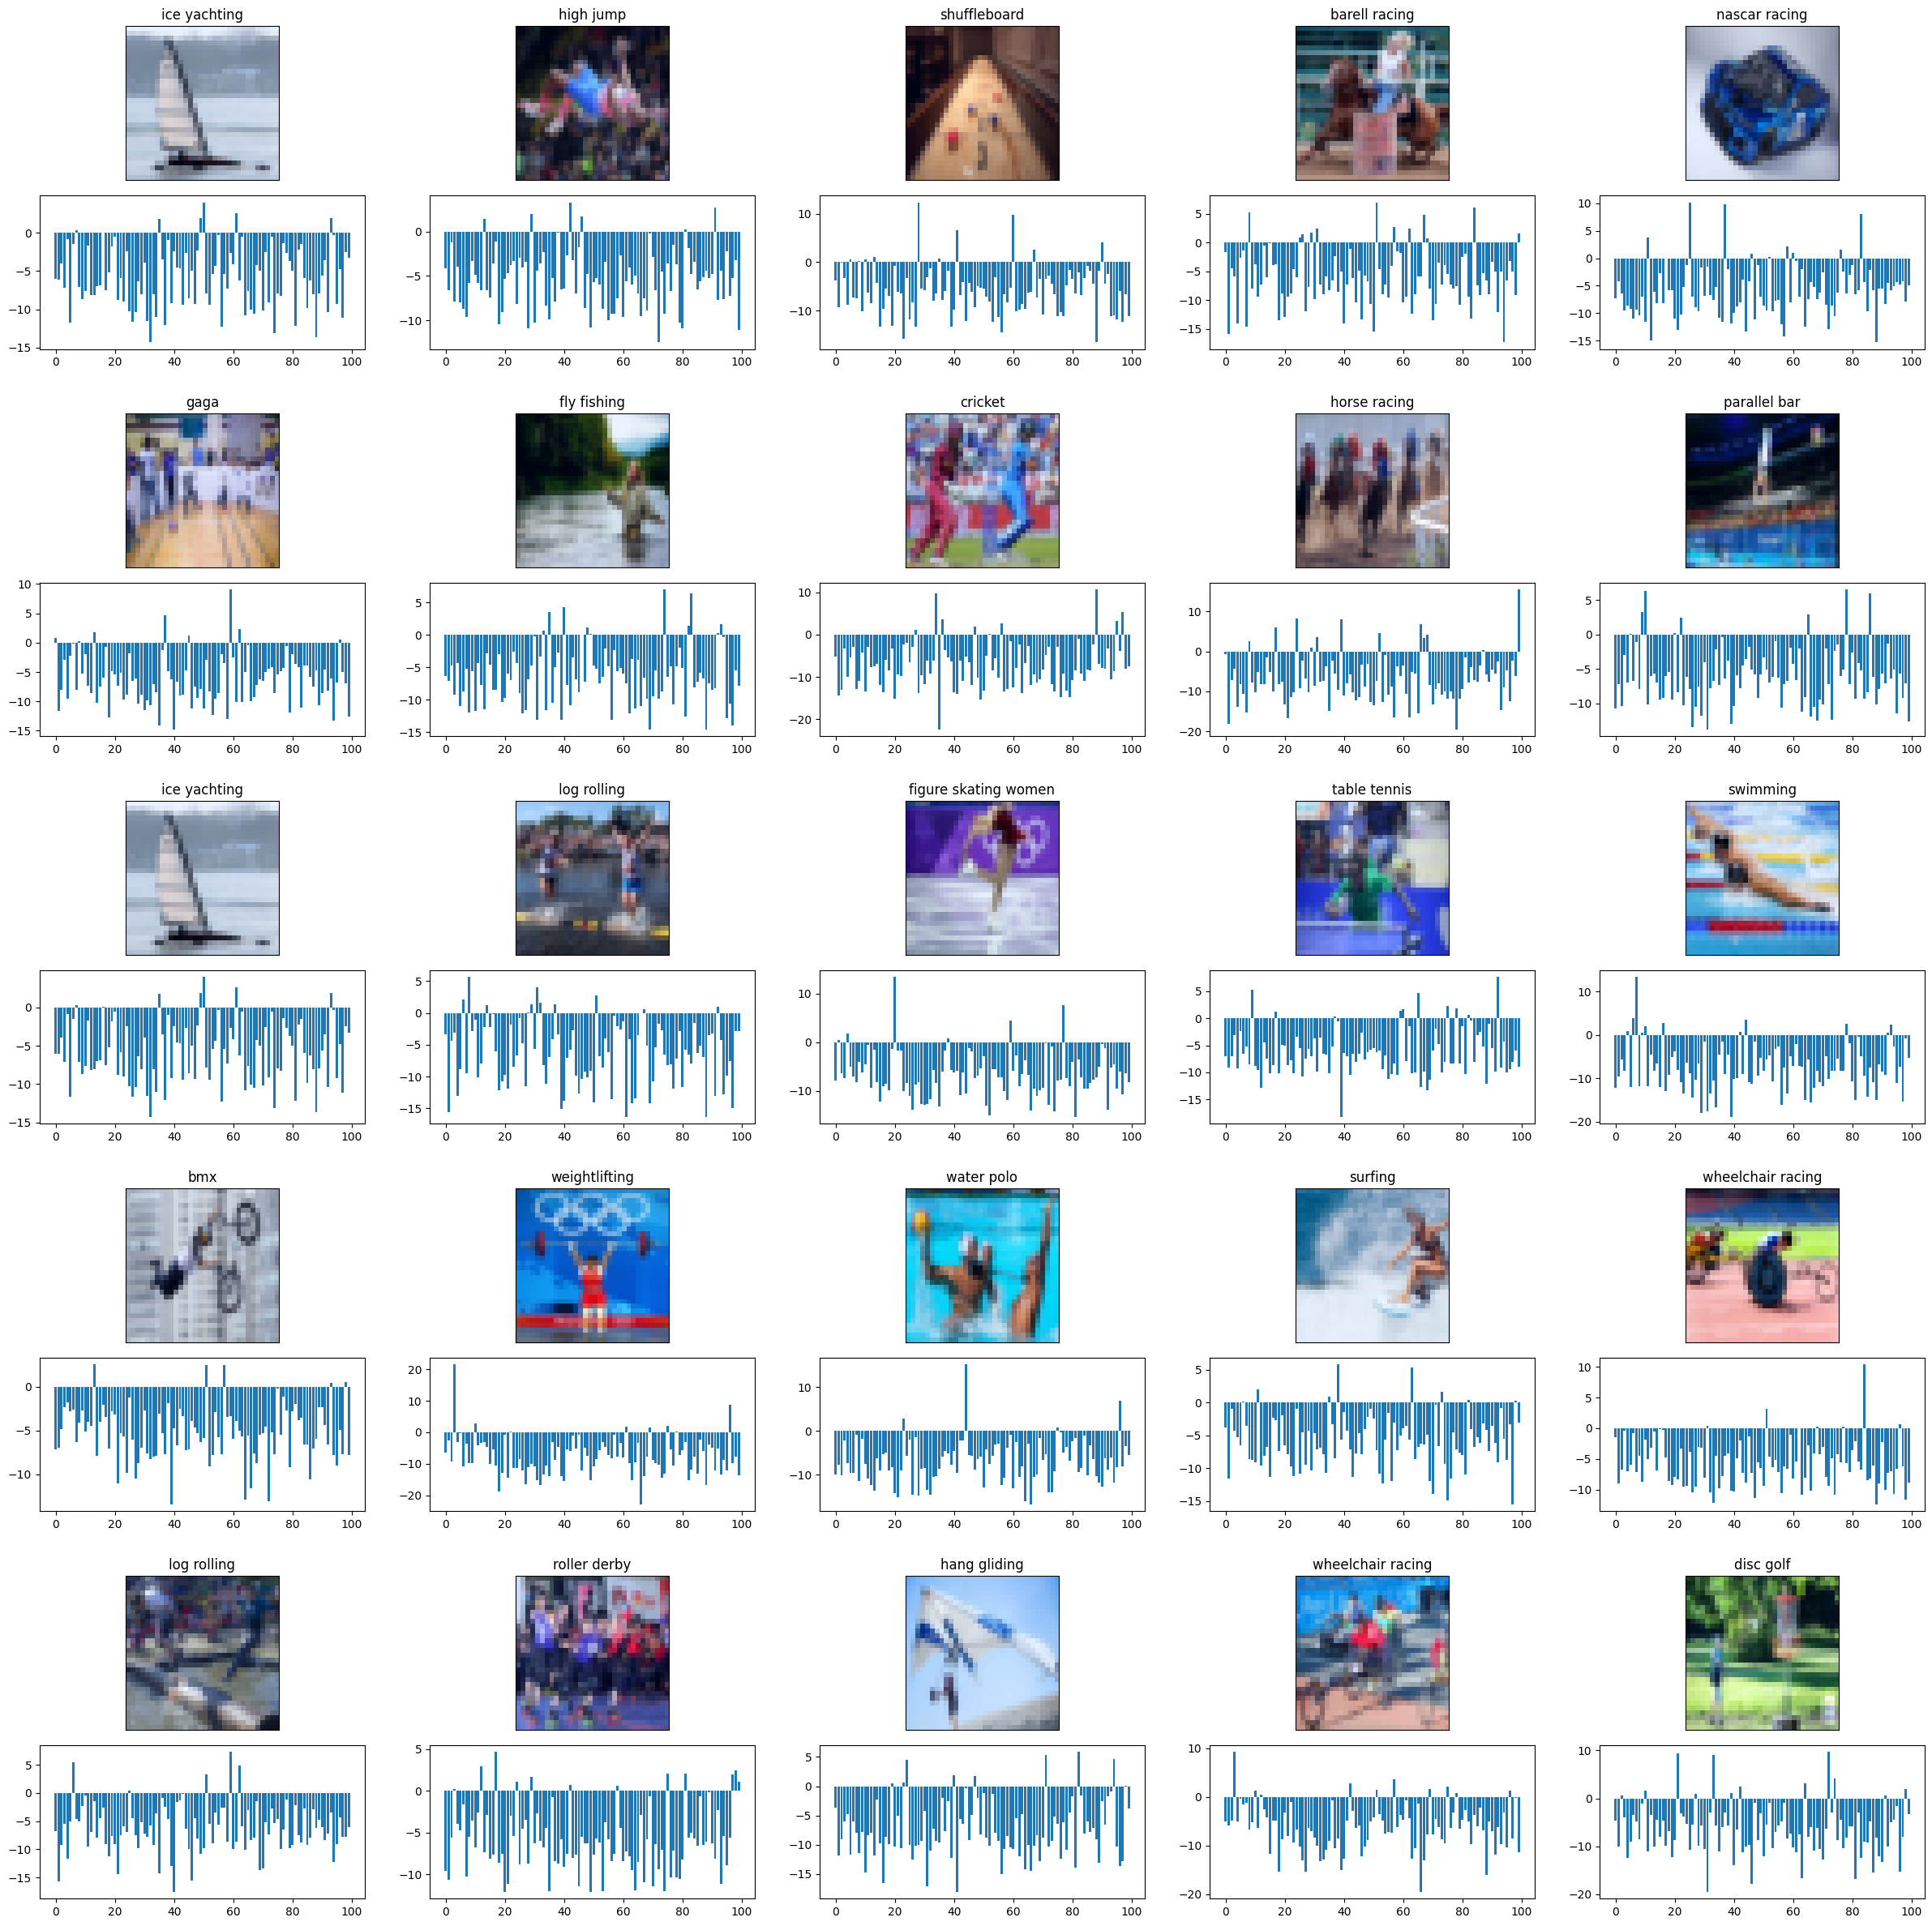

In [ ]:
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
from random import randint
import numpy as np

fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)
# get_classlabels = {0:'Fake', 1:'Real'}

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(testset))
    # img = testset[2][0]
    # print(img.shape)
    # break

    pred_image = testset[rnd_number][0].cuda().unsqueeze(0)
    # pred_class = get_classlabel(torch.argmax(model(pred_image)))
    pred_class = get_classlabels[testset[rnd_number][1]]
    pred_prob = model(pred_image).reshape(100)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            pred_image = (pred_image - torch.min(pred_image))/(torch.max(pred_image) - torch.min(pred_image))
            ax.imshow(pred_image[0].permute(1, 2, 0).cpu().numpy())
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([i for i in range(100)],pred_prob.detach().cpu().numpy())
            fig.add_subplot(ax)


fig.show()